## Beamforming Model for San Juan Hydrophone VLA

Isabelle Brandicourt, March 21, 2025

In [8]:
import arlpy.uwapm as pm
import numpy as np
import matplotlib.pyplot as plt
import random

In [9]:
# Define the range and depth grid
range_values = np.arange(0, 500, 5)  # Range in meters
depth_values = np.arange(0, 240, 5)  # Depth in meters (avoid 0 m)
RangeGrid, DepthGrid = np.meshgrid(range_values, depth_values)

# Define the receiver positions
receiver_depths = [48, 96, 144, 192]   # Receiver depth in meters
rx_arrays = [[], [], [], []]

In [10]:
for calculating_depth in range(4):
    source_level_array = np.zeros_like(RangeGrid, dtype=float)      # generate temporary array for set depth
    r_mesh, d_mesh = np.meshgrid(RangeGrid[0,:], depth_values)      # Create mesh grids for vectorized operations

    # Mark invalid configurations (r=0 or d=0) and get the valid indices
    invalid_mask = (r_mesh == 0) | (d_mesh == 0)
    source_level_array[invalid_mask] = -np.inf
    valid_indices = np.where(~invalid_mask)

    # Vectorized environment creation and calculation, then vectorize the processing function
    def process_cell(r, d):
        env = pm.create_env2d(
            depth=240,
            soundspeed=1483,
            bottom_soundspeed=1480,
            bottom_density=1200,
            bottom_absorption=1.0,
            frequency=1000,
            tx_depth=d,
            rx_range=r,
            rx_depth=receiver_depths[calculating_depth]
        )
        
        try:
            arrivals = pm.compute_arrivals(env)
            if arrivals is not None and not arrivals.empty:
                amplitude_magnitude = np.abs(arrivals['arrival_amplitude'])
                total_intensity = np.sum(amplitude_magnitude**2)
                return 10 * np.log10(total_intensity)
            return -np.inf
        except Exception:
            return -np.inf

    v_process_cell = np.vectorize(process_cell, otypes=[float])
    source_level_array[valid_indices] = v_process_cell(r_mesh[valid_indices], d_mesh[valid_indices])        # Calculate for valid positions

    rx_arrays[calculating_depth] = source_level_array

(48, 100)
20.0 20.0
Receiver Depth 48m: Value at (100m, 100m) = -39.59 dB


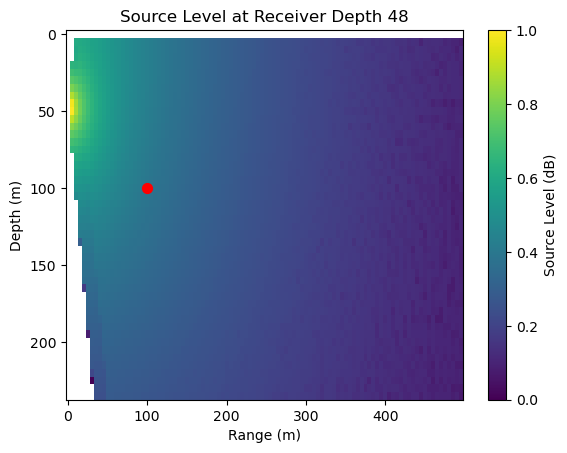

20.0 20.0
Receiver Depth 96m: Value at (100m, 100m) = -39.19 dB


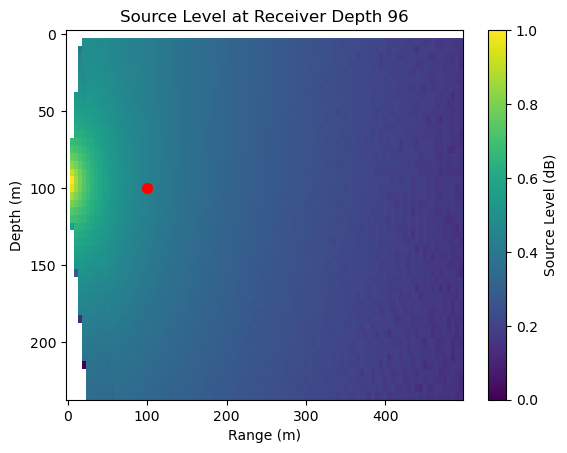

20.0 20.0
Receiver Depth 144m: Value at (100m, 100m) = -40.08 dB


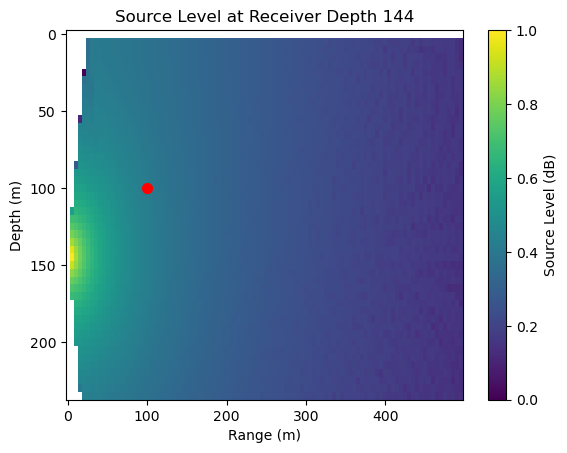

20.0 20.0
Receiver Depth 192m: Value at (100m, 100m) = -41.89 dB


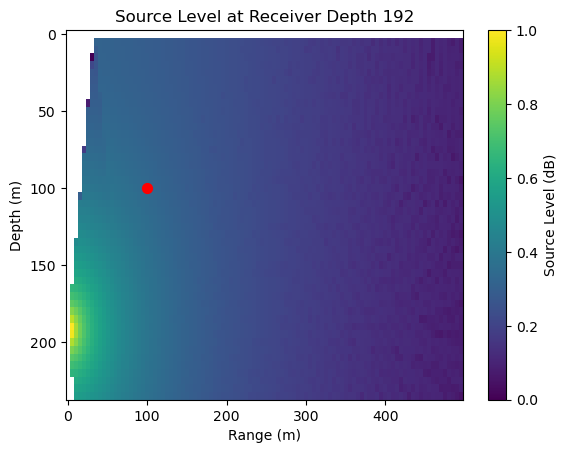

In [5]:
print((rx_arrays[1].shape))

for k, receiver_depth in enumerate(receiver_depths):
    plt.figure()
    plt.pcolormesh(RangeGrid, DepthGrid, rx_arrays[k], shading='auto')
    
    plt.scatter(100, 100, color='red', s=50, label='Target (100m, 100m)')
    range_idx = 100/5
    depth_idx = 100/5
    print(range_idx, depth_idx)
    value_at_point = rx_arrays[k][int(range_idx), int(depth_idx)]
    print(f"Receiver Depth {receiver_depth}m: Value at (100m, 100m) = {value_at_point:.2f} dB")

    plt.colorbar(label='Source Level (dB)')
    plt.xlabel('Range (m)')
    plt.ylabel('Depth (m)')
    plt.title(f'Source Level at Receiver Depth {receiver_depth}')
    plt.gca().invert_yaxis()
    plt.show()

### Get the levels at a specific point and then add some noise to it

In [7]:
# get a random point in the range
range_rand = random.randint(0, 500)
depth_rand = random.randint(0, 240)

print(f"Random Point: ({range_rand}, {depth_rand})")

env['tx_depth']=depth_rand
env['rx_range']=range_rand

Random Point: (497, 180)


NameError: name 'env' is not defined